In [1]:
# set up
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from collections import defaultdict
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split

import scipy.stats as sstats 
from tqdm import tqdm
from sklearn import (datasets, decomposition, ensemble, manifold, random_projection)

In [2]:
def standarize(X):
    m = np.mean(X, 0).reshape(1, -1)
    s = np.std(X, 0).reshape(1, -1)
    
    return (X - m) / (s + 1e-10)

# 2nd Task

In [3]:
train = pd.read_csv('face_train.csv', header=None).astype(np.float64).T.values
test = pd.read_csv('face_test.csv', header=None).astype(np.float64).T.values

In [4]:
print(train.shape)
train

(250, 4920)


array([[ 34.16666667,  31.5       ,  31.75      , ..., 249.08333333,
        244.91666667, 243.75      ],
       [230.        ,  53.25      ,  38.33333333, ..., 244.25      ,
        244.83333333, 244.58333333],
       [ 34.08333333,  29.91666667,  30.5       , ..., 245.41666667,
        244.66666667, 245.        ],
       ...,
       [ 36.41666667,  40.66666667,  38.75      , ...,  34.91666667,
         31.        ,  28.        ],
       [ 49.75      ,  35.58333333,  37.25      , ...,  22.08333333,
         21.33333333,  21.75      ],
       [ 73.41666667,  42.58333333,  41.41666667, ..., 216.08333333,
         59.16666667,  57.91666667]])

## 2.1. Example images

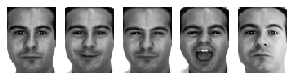

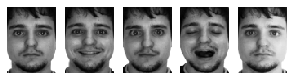

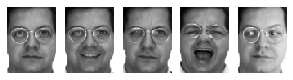

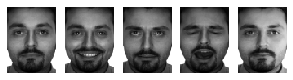

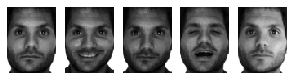

In [5]:
for i in range(5):
    f, ax = plt.subplots(1,5, figsize=(5,10))
    for j in range(5):
        img = train[5 * i + j].reshape(60,82).T
        ax[j].imshow(img, cmap='gray')
        ax[j].axis('off')

In [6]:
%%time
Sigma = np.cov(standarize(train).T)
v, w = LA.eig(Sigma)

CPU times: user 2min 32s, sys: 5.25 s, total: 2min 37s
Wall time: 1min 31s


In [19]:
train_pca = w[:, :60].T.dot(standarize(train).T).T \
            / np.sqrt(v[:60]).reshape(1, -1)
train_pca = np.real(train_pca)

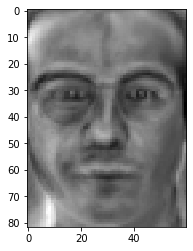

In [21]:
tmp = train_pca[0] * np.sqrt(v[:60]).reshape(1, -1)
tmp = np.dot(tmp, w[:, :60].T)
tmp = np.real(tmp)
plt.imshow(tmp.reshape(60, 82).T, cmap='gray')

## 2.2 Eigenvectors from w

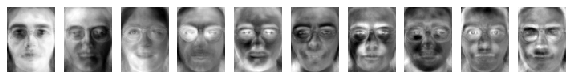

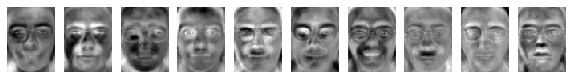

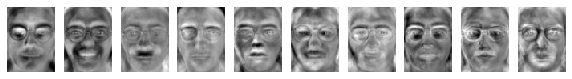

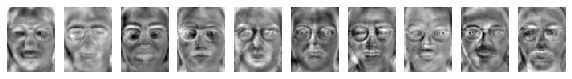

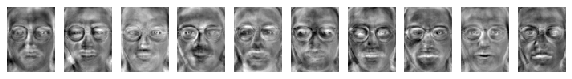

In [127]:
for i in range(5):
    f, ax = plt.subplots(1,10, figsize=(10,10))
    for j in range(10):
        img = np.real(w[:, 5*i+j]).reshape(60, 82).T
        ax[j].imshow(img, cmap='gray')
        ax[j].axis('off')

(250, 70)
(70, 4920)


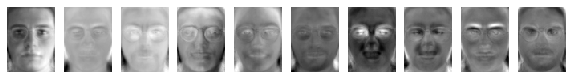

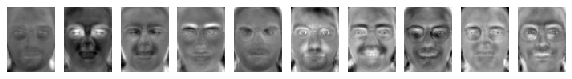

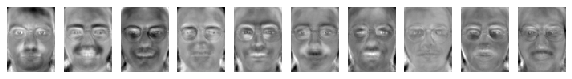

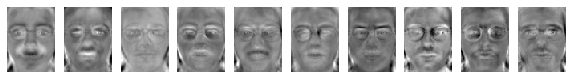

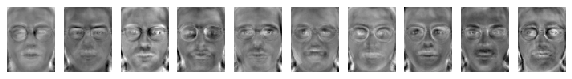

In [128]:
# using sklearn
sk_pca = PCA(n_components=70)
sk_x = sk_pca.fit_transform(train)
print(sk_x.shape)
print(sk_pca.components_.shape)
for i in range(5):
    f, ax = plt.subplots(1,10, figsize=(10,10))
    for j in range(10):
        img = sk_pca.components_.T[:, 5*i+j].reshape(60, 82).T
        ax[j].imshow(img, cmap='gray')
        ax[j].axis('off')

# 3rd Task

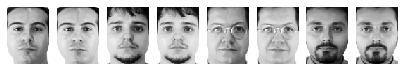

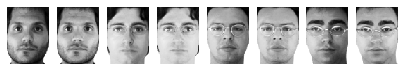

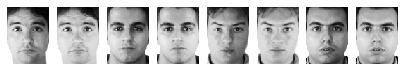

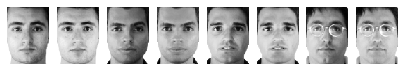

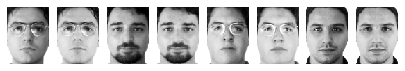

In [129]:
# test data
for i in range(5):
    f, ax = plt.subplots(1,8, figsize=(7,10))
    for j in range(8):
        img = test[8*i+j].reshape(60,82).T
        ax[j].imshow(img, cmap='gray')
        ax[j].axis('off')

In [254]:
def classify(img, X=train, PCA=False):
    if PCA:
        X = standarize(X)
        img = standarize(img)
    
        X = w[:, :PCA].T.dot(X.T).T / np.sqrt(v[:PCA])
        img = w[:, :PCA].T.dot(img.T).T / np.sqrt(v[:PCA])

        img = np.real(img)
        X = np.real(X)

    dists = np.sum((X - img) ** 2, axis=1)
    dists = np.sqrt(dists)
    
    closest = np.argmin(dists)
    return closest // 5, dists[closest]


def classify_all(X=train, Y=test, PCA=False):
    if PCA:
        X = standarize(X)
        Y = standarize(Y)
    
        X = w[:, :PCA].T.dot(X.T).T / np.sqrt(v[:PCA])
        Y = w[:, :PCA].T.dot(Y.T).T / np.sqrt(v[:PCA])

        X = np.real(X)
        Y = np.real(Y)

    dists = -2 * np.dot(Y, X.T) + np.sum(X.T**2, axis=0)
    closest = np.argmin(dists, axis=1) // 5
    
    return closest


def show_similar(img, X=train, PCA=False):
    person, dist = classify(img, X, PCA)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 5))
    axes[0].imshow(img.reshape(60, 82).T, cmap='gray')
    axes[0].set_title('Unknown person')
    axes[1].imshow(train[person].reshape(60, 82).T, cmap='gray')
    axes[1].set_title(f'Closest person, dist: {dist:.3f}')

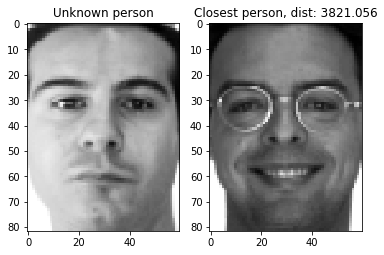

In [255]:
show_similar(test[0])

In [256]:
preds = classify_all(X=train, Y=test)
y = np.array([i // 2 for i in range(100)])
print(f'Acc: {(preds == y).mean() * 100}%')

Acc: 17.0%


# 4th Task

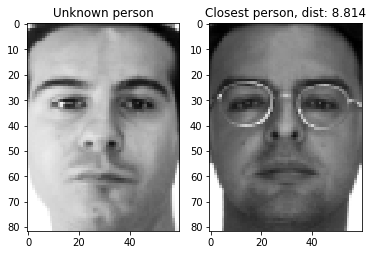

In [191]:
show_similar(test[0], X=train_pca, PCA=80)

In [198]:
preds = classify_all(X=train, Y=test, PCA=40)
y = np.array([i // 2 for i in range(100)])
print(f'Acc: {(preds == y).mean() * 100}%')

Acc: 100.0%


# 5th Task

In [368]:
def KNN(k, labels, X, Y, PCA=False):
    if PCA:
        X = standarize(X)
        Y = standarize(Y)
    
        X = w[:, :PCA].T.dot(X.T).T / np.sqrt(v[:PCA])
        Y = w[:, :PCA].T.dot(Y.T).T / np.sqrt(v[:PCA])

        X = np.real(X)
        Y = np.real(Y)
        
    dists = -2 * np.dot(Y, X.T) + np.sum(X.T ** 2, axis=0)
    closest = np.argsort(dists, axis=1)
    closest = closest[:, :k]
    closest = labels[closest]
    targets = sstats.mode(closest, axis=1)[0]

    return targets

In [356]:
all_photos = np.array([train[(i//7) * 5 + i % 5] if i % 7 < 5 \
                       else test[(i // 7) * 2 + i % 2] for i in range(350)])

In [369]:
# try knn
ys = np.array([i // 2 for i in range(len(test))])
xs = np.array([i // 5 for i in range(len(train))])
try_knn = KNN(1, labels=xs, X=train, Y=test).ravel()
print(f'No PCA: {(try_knn == ys).mean()*100}%')
try_knn = KNN(1, labels=xs, X=train, Y=test, PCA=40).ravel()
print(f'PCA: {(try_knn == ys).mean()*100}%')

No PCA: 17.0%
PCA: 100.0%


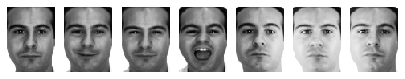

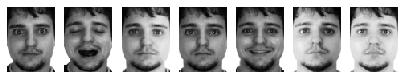

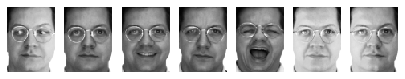

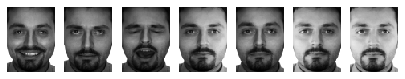

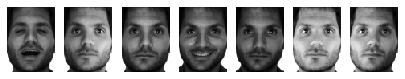

In [201]:
for i in range(5):
    f, ax = plt.subplots(1,7, figsize=(7,10))
    for j in range(7):
        img = all_photos[7*i+j].reshape(60,82).T
        ax[j].imshow(img, cmap='gray')
        ax[j].axis('off')

In [384]:
def cross_validation(X, no=10, PCA=False, debug=False):
    hist = []
    if debug:
        print(f'Cross validation with split on {no}, PCA: {PCA}\n')
    ks = np.arange(1,14,2)
    for k in ks:
        if debug:
            print(f'k = {k}')
        avg_score = 0
        indices = np.random.uniform(0, no, len(X)).astype(int)

        for i in range(no):
            x_train = X[indices != i]
            y_train = np.array([i // 7 for i, b in enumerate(indices != i) if b])
            
            x_test = X[indices == i]
            y_test = np.array([i // 7 for i, b in enumerate(indices == i) if b])

            preds = KNN(k=k, labels=y_train, X=x_train, Y=x_test, PCA=PCA).ravel()
            score = (preds == y_test).mean()
            avg_score += score
#             print(f'k: {k}\nAcc: {score * 100:.3f}%\n')
        hist.append([PCA, k, avg_score / no])
        if debug:
            print(f'Final acc: {avg_score / no * 100 :.3f}%\n')
    
    return hist

In [385]:
_ = cross_validation(X=all_photos, no=10, PCA=False, debug=True)

Cross validation with split on 10, PCA: False

k = 1
Final acc: 51.169%

k = 3
Final acc: 41.555%

k = 5
Final acc: 33.965%

k = 7
Final acc: 28.175%

k = 9
Final acc: 22.794%

k = 11
Final acc: 20.659%

k = 13
Final acc: 15.922%



In [383]:
_ = cross_validation(X=all_photos, no=10, PCA=60, debug=True)

Cross validation with split on 10, PCA: 60

k = 1
Final acc: 84.708%

k = 3
Final acc: 73.195%

k = 5
Final acc: 70.720%

k = 7
Final acc: 72.431%

k = 9
Final acc: 65.529%

k = 11
Final acc: 68.698%

k = 13
Final acc: 60.987%



In [413]:
%%time
dim = [10, 20, 50, 70, 100, 200, 300, 500, 1000]
H = []
for d in tqdm(dim, desc='Cross validating different dimentions', position=0):
    H.append(cross_validation(X=all_photos, no=10, PCA=d, debug=False))

Cross validating different dimentions: 100%|█████████████████████████████████████████████| 9/9 [01:02<00:00,  7.00s/it]


Wall time: 1min 2s


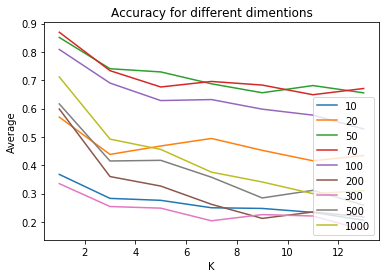

In [414]:
H = np.array(H)
plt.title('Accuracy for different dimentions')
plt.xlabel('K')
plt.ylabel('Average')
for i in range(len(dim)):
    plt.plot(H[i][:, 1], H[i][:, 2], label=dim[i])
plt.legend(loc='lower right')

# 6th Task

In [423]:
def plot_digits(X, y):
    X = (X - np.min(X, 0)) / (np.max(X, 0) - np.min(X, 0))

    plt.figure(figsize=(12, 9))

    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(0.1*y[i]), fontdict={'weight':'bold', 'size':8})

    plt.xticks([])
    plt.yticks([])
    plt.show()

In [440]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
N, d = X.shape

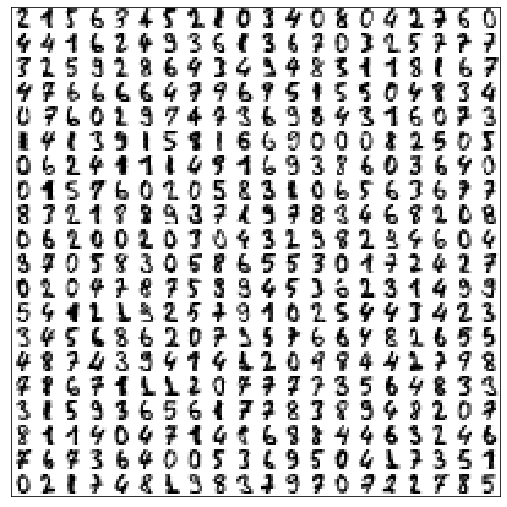

In [419]:
M = 20
image = np.zeros((10 * M, 10 * M))
order = np.random.permutation(N)
for i in range(M):
    for j in range(M):
        image[10*i+1:10*i+9, 10*j+1:10*j+9] = X[order[i*M+j], :].reshape((8, 8))

plt.figure(figsize=(9, 9))
plt.imshow(image, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()

## 6.1 Random projection

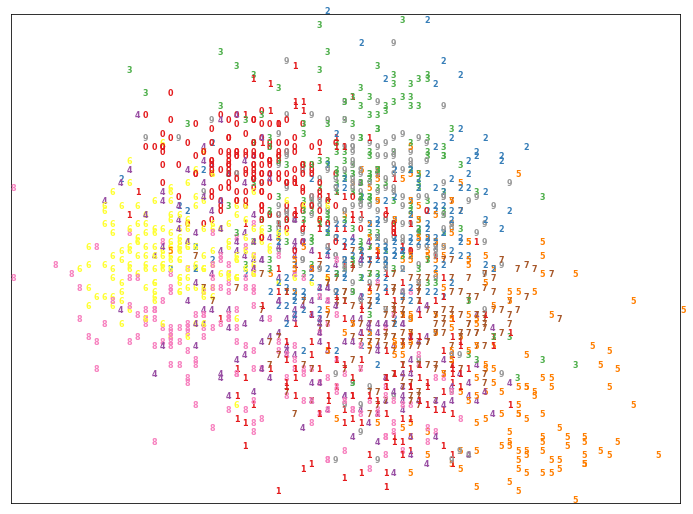

In [424]:
X_projected = random_projection.SparseRandomProjection(n_components=2).fit_transform(X)
plot_digits(X_projected, digits.target)

## 6.2 PCA

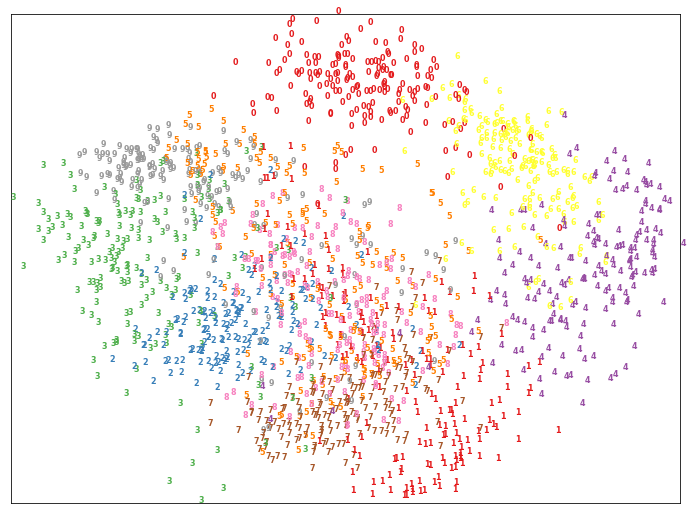

In [425]:
X_pca = decomposition.PCA(n_components=2,whiten=True).fit_transform(X)
plot_digits(X_pca, digits.target)

## 6.3 KPCA (kernel)

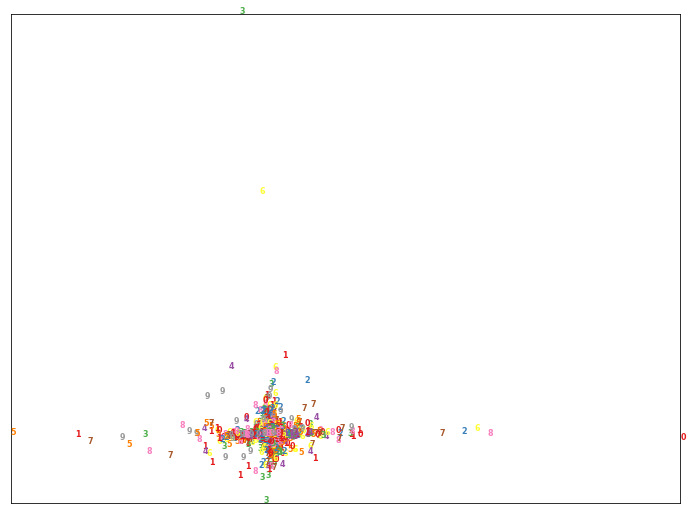

In [428]:
X_kpca = decomposition.KernelPCA(n_components=2, kernel="rbf", gamma=10).fit_transform(X)
plot_digits(X_kpca, digits.target)

## 6.4 Isomap

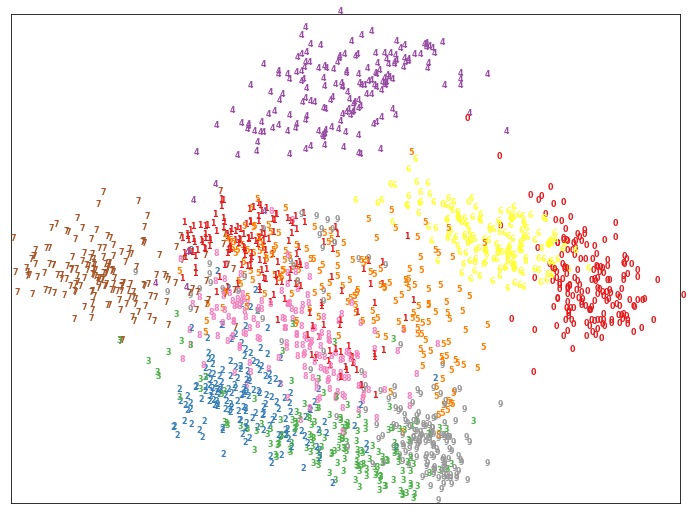

In [429]:
X_iso = manifold.Isomap(30, n_components=2).fit_transform(X)
plot_digits(X_iso, digits.target)

## 6.5 Locally Linear Embedding (LLE)

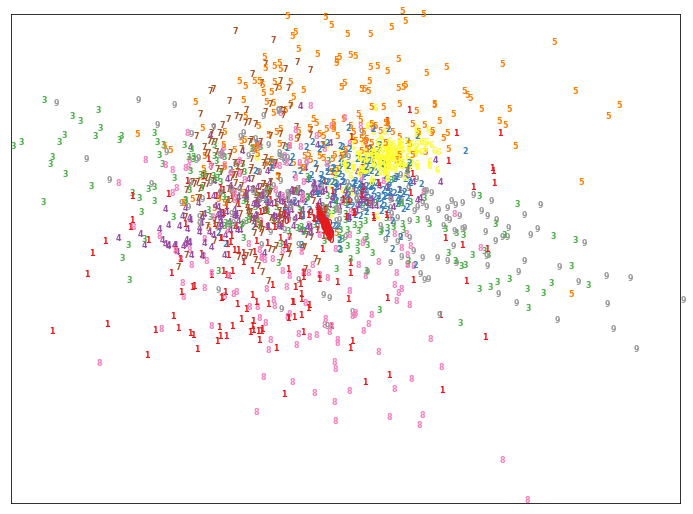

In [430]:
X_lle = manifold.LocallyLinearEmbedding(30, n_components=2).fit_transform(X)
plot_digits(X_lle, digits.target)

## 6.6 Multidimensional Scaling (MDS)

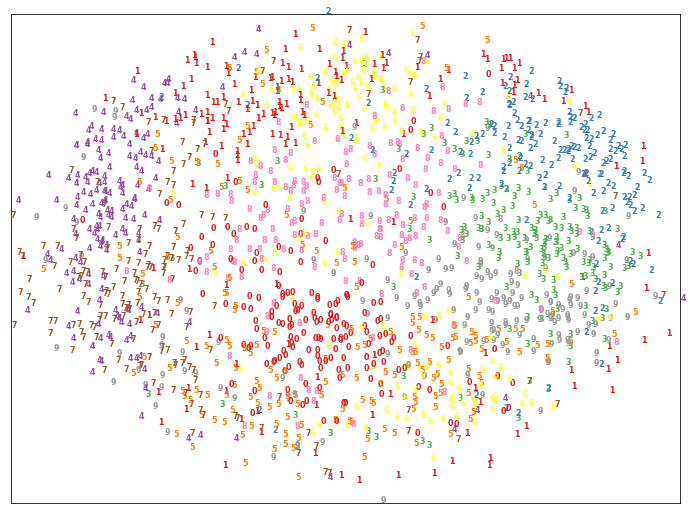

In [431]:
X_mds = manifold.MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)
plot_digits(X_mds, digits.target)

## 6.7 t-distributed Stochastic Neighbor Embedding (t-SNE)

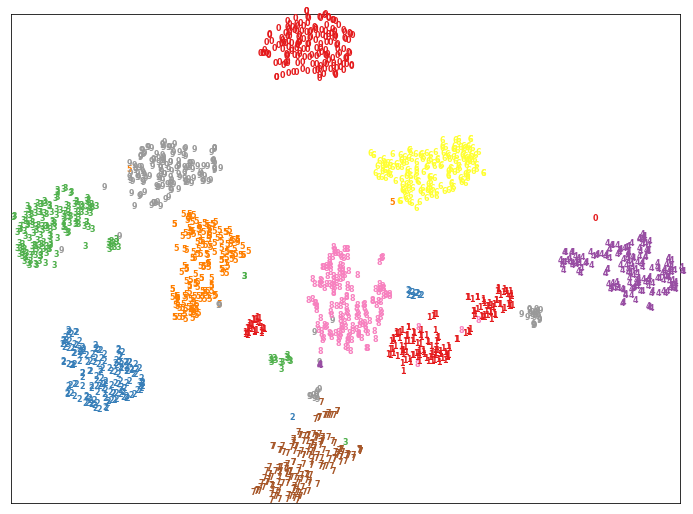

In [432]:
X_tsne = manifold.TSNE(n_components=2, init='pca').fit_transform(X)
plot_digits(X_tsne, digits.target)

# 7th Task

In [714]:
def KNN(train_X, train_Y, test_X, ks):
    train_X = train_X.astype(np.float64)
    test_X = test_X.astype(np.float64)
    
    dists = -2 * np.dot(test_X, train_X.T) + np.sum(train_X.T**2, axis=0)
    closest = np.argsort(dists, axis=1)
    targets = train_Y[closest]

    preds = {}
    for k in ks:
        predictions = sstats.mode(targets[:, :k], axis=1)[0]
        preds[k] = predictions.ravel()
  
    return preds

In [715]:
X_train, X_test, y_train, y_test = train_test_split(
    X, digits.target, test_size=0.33)
X_train.shape, X_test.shape

((1203, 64), (594, 64))

In [774]:
%%time
model = random_projection.SparseRandomProjection(n_components=2)
X_projected = model.fit_transform(X_train)
X_projected_t = model.transform(X_test)
model = decomposition.PCA(n_components=2,whiten=True)
X_pca = model.fit_transform(X_train)
X_pca_t = model.transform(X_test)
model = decomposition.KernelPCA(n_components=2, kernel="rbf", gamma=10)
X_kpca = model.fit_transform(X_train)
X_kpca_t = model.transform(X_test)
model = manifold.Isomap(20, n_components=2)
X_iso = model.fit_transform(X_train)
X_iso_t = model.transform(X_test)
model = manifold.LocallyLinearEmbedding(12, n_components=2)
X_lle = model.fit_transform(X_train)
X_lle_t = model.transform(X_test)

stacked_data = np.vstack([X_train, X_test])
model = manifold.MDS(n_components=2, n_init=1, max_iter=100, metric=True)
X_mds_t = model.fit_transform(stacked_data)[X_train.shape[0]:, :]
X_mds = model.fit_transform(stacked_data)[:X_train.shape[0], :]
model = manifold.TSNE(n_components=2, init='pca', perplexity=10)
X_tsne_t = model.fit_transform(stacked_data)[X_train.shape[0]:, :]
X_tsne = model.fit_transform(stacked_data)[:X_train.shape[0], :]

data = [X_train, X_projected, X_pca, X_kpca, X_iso, X_lle, X_mds, X_tsne]
data_t = [X_test, X_projected_t, X_pca_t, X_kpca_t, X_iso_t, X_lle_t, X_mds_t, X_tsne_t]
names = ['OG', 'Random', 'PCA', 'KPCA', 'Isomap', 'LLE', 'MDS', 't-SNE']

Wall time: 38.6 s


In [775]:
%%time
ks = np.arange(1, 22, 2)
all_preds = np.array([KNN(data[i], y_train, data_t[i], ks) for i in range(len(data))])

Wall time: 3.01 s


In [779]:
res = defaultdict(list)
for i, preds in enumerate(all_preds):
    for k, p in preds.items():
        score = (p == y_test).mean()
        res[k].append(round(score,3))

In [780]:
df = pd.DataFrame.from_dict(res, orient='index', columns=names)
df

,OG,Random,PCA,KPCA,Isomap,LLE,MDS,t-SNE
1,0.987,0.253,0.586,0.114,0.785,0.822,0.189,0.988
3,0.980,0.229,0.599,0.114,0.806,0.855,0.199,0.988
5,0.983,0.244,0.633,0.111,0.816,0.859,0.195,0.990
7,0.981,0.283,0.650,0.114,0.828,0.867,0.199,0.990
9,0.980,0.285,0.650,0.114,0.822,0.869,0.200,0.988
11,0.980,0.283,0.646,0.114,0.827,0.865,0.192,0.985
13,0.975,0.298,0.645,0.089,0.822,0.862,0.189,0.981
15,0.980,0.293,0.652,0.089,0.828,0.859,0.189,0.976
17,0.973,0.290,0.645,0.089,0.832,0.860,0.182,0.970
19,0.965,0.296,0.655,0.089,0.825,0.860,0.194,0.965


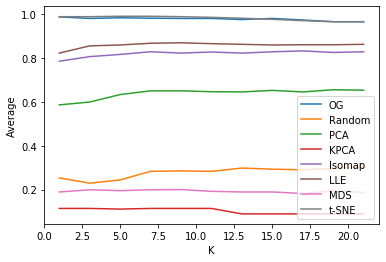

In [781]:
plt.xlabel('K')
plt.ylabel('Average')
for i, col in enumerate(df.columns):
    plt.plot(ks, df[col], label=names[i])
plt.legend(loc='lower right')